# Analysis results

In this notebook we'll try to get the some idea about the final sensitivity of the trilep channel.


First, we import all the packages we need and load histograms from a cache.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re

import numpy as np
import pandas as pd

from coffea import hist

from klepto.archives import dir_archive

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import makePlot
from Tools.config_helpers import get_cache

In [2]:
output = get_cache('SS_analysis_2018')

In [3]:
# redefine some labels and colors
my_labels = {
        'topW_v3': 'top-W scat.',
        'topW_EFT_cp8': 'EFT, cp8',
        'topW_EFT_mix': 'EFT mix',
        'TTZ': r'$t\bar{t}Z$',
        'TTW': r'$t\bar{t}W$',
        'TTH': r'$t\bar{t}H$',
        'diboson': 'VV/VVV',
        'rare': 'rare',
        'ttbar': r'$t\bar{t}$',
        'XG': 'XG',  # this is bare XG
        'conv_mc': 'conversion',
        'np_obs_mc': 'nonprompt (MC true)',
        'np_est_mc': 'nonprompt (MC est)',
        'cf_obs_mc': 'charge flip (MC true)',
        'cf_est_mc': 'charge flip (MC est)',
        'np_est_data': 'nonprompt (est)',
        'cf_est_data': 'charge flip (est)',
}

my_colors = {
        'topW_v3': '#FF595E',
        'topW_EFT_cp8': '#000000',
        'topW_EFT_mix': '#0F7173',
        'TTZ': '#FFCA3A',
        'TTW': '#8AC926',
        'TTH': '#34623F',
        'diboson': '#525B76',
        'rare': '#EE82EE',
        'ttbar': '#1982C4',
        'XG': '#5bc0de',
        'conv_mc': '#5bc0de',
        'np_obs_mc': '#1982C4',
        'np_est_mc': '#1982C4',
        'np_est_data': '#1982C4',
        'cf_obs_mc': '#0F7173',
        'cf_est_mc': '#0F7173',
        'cf_est_data': '#0F7173',
}

Data: 0 MC: 53.38


/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/coffea/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


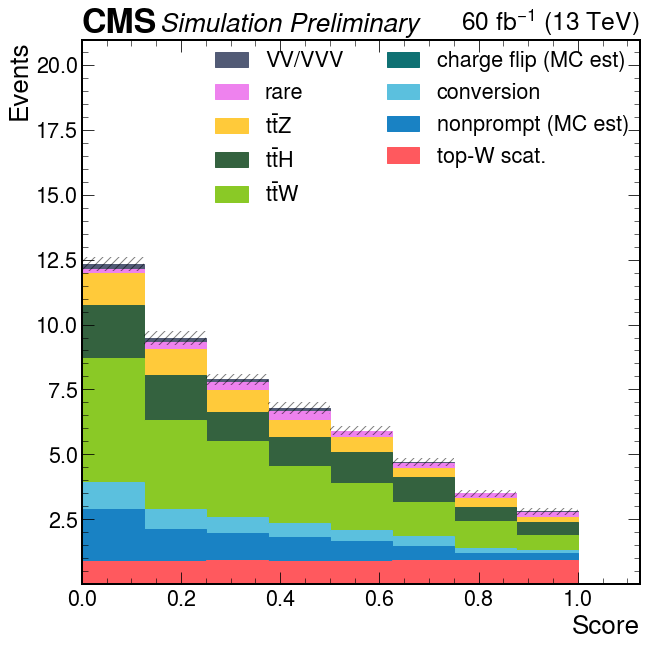

In [4]:
# check out that the histogram we want is actually there
all_processes = [ x[0] for x in output['N_ele'].values().keys() ]
data_all = ['DoubleMuon', 'MuonEG', 'EGamma', 'SingleMuon']
data    = data_all
order   = ['topW_v3', 'np_est_mc', 'conv_mc', 'cf_est_mc', 'TTW', 'TTH', 'TTZ','rare', 'diboson']
signals = []
omit    = [ x for x in all_processes if (x not in signals and x not in order and x not in data) ]

lumi = 60

score_bins = hist.Bin("score",          r"N", 8, 0, 1)

makePlot(output, 'node0_score_transform_pp', 'score',
     data=[],
     bins=score_bins, log=False, normalize=False, axis_label='Score',
     new_colors=my_colors, new_labels=my_labels, lumi=lumi,
     order=order,
     signals=signals,
     omit=omit+data,
     #save=os.path.expandvars(plot_dir+sub_dir+'node0_score_transform_pp'),
    )

Data: 0 MC: 350.72


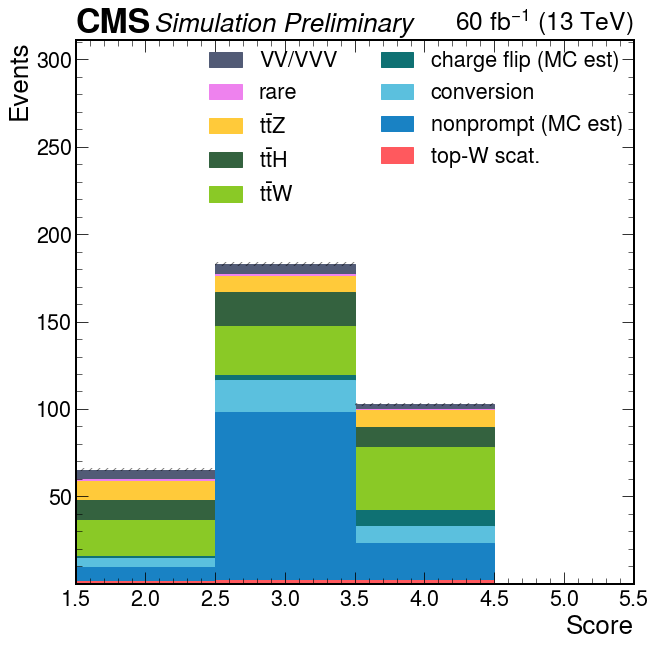

In [5]:
N_bins = hist.Bin("multiplicity", r"N", 3, 1.5, 4.5)

makePlot(output, 'node', 'multiplicity',
     data=[],
     bins=N_bins, log=False, normalize=False, axis_label='Score',
     new_colors=my_colors, new_labels=my_labels, lumi=lumi,
     order=order,
     signals=signals,
     omit=omit+data,
     #save=os.path.expandvars(plot_dir+sub_dir+'node0_score_transform_pp'),
    )

# Limits

A few tools are in place that interface with the [combine tool](https://github.com/cms-analysis/HiggsAnalysis-CombinedLimit), documentation can be found [here](http://cms-analysis.github.io/HiggsAnalysis-CombinedLimit/). The statistical backgrounds can be found in [this paper](https://cds.cern.ch/record/1379837?ln=en).


In [6]:
from Tools.dataCard import dataCard
from Tools.limits import makeCardFromHist

In order for this to run we first need to install the combine tool.

In your terminal on the uaf:
- navigate to your home directory
- make a new directory called "combine"

Then run the following commands:
```
cd combine
cmsrel CMSSW_10_2_13
cd CMSSW_10_2_13/src
cmsenv
git clone https://github.com/cms-analysis/HiggsAnalysis-CombinedLimit.git HiggsAnalysis/CombinedLimit
cd HiggsAnalysis/CombinedLimit
git fetch origin
git checkout v8.0.1
scramv1 b clean; scramv1 b # always make a clean build
```


In [7]:
card = dataCard(releaseLocation=os.path.expandvars('/home/users/$USER/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/'))

Before we can start, we need to get the histogram in the correct shape.
We want to:
- Remove real data entries
- Any signal processes we're not interested in right now, like topW_EFT_cp8 and topW_EFT_mix
- Group DY and diboson into a *rare* category, and keep all others
- Rebin the mass axis to something sensible, similar to what we've done above.

For removing datasets we don't want to look at we can use regular expressions (the *re* package)

In [8]:
no_data_or_signal  = re.compile('(?!(%s))'%('|'.join(omit)))

regions = [
    ('SR_1', 'node0_score_transform_pp'),
    ('SR_2', 'node0_score_transform_mm'),
    ('CR', 'node1_score'),
    ('CR_ext', 'node'),
]

mapping = {
    'rare': ['rare', 'diboson'],
    'TTW': ['TTW'],
    'TTZ': ['TTZ'],
    'TTH': ['TTH'],
    'ttbar': ['ttbar'],
    'nonprompt': ['np_est_mc'],
    'chargeflip': ['cf_est_mc'],
    'conversion': ['conv_mc'],
    'signal': ['topW_v3'],
}

new_hists = {}
for short_name, long_name in regions:
    new_hists[short_name] = output[long_name][no_data_or_signal]
    if short_name.count('CR_ext')<1:
        new_hists[short_name] = new_hists[short_name].rebin('score', score_bins)
    else:
        new_hists[short_name] = new_hists[short_name].rebin('multiplicity', N_bins)
    new_hists[short_name] = new_hists[short_name].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)

In [9]:
# check that all of this actually worked
for process in list(new_hists['CR'].values().keys()):
    print (process[0])

rare
TTW
TTZ
TTH
nonprompt
chargeflip
conversion
signal


In [10]:
new_hists['SR_1'].values()

{('rare',): array([0.3397638 , 0.40279181, 0.40361527, 0.4578172 , 0.24670906,
        0.22030257, 0.20642681, 0.20758181]),
 ('TTW',): array([4.75283921, 3.44733368, 2.92498049, 2.20506371, 1.81005991,
        1.33835328, 1.0198009 , 0.56793452]),
 ('TTZ',): array([1.23300327, 1.02812572, 0.85268732, 0.66302686, 0.57025626,
        0.36151641, 0.31504013, 0.19645201]),
 ('TTH',): array([2.04966786, 1.69920578, 1.12642817, 1.11778673, 1.20761551,
        0.94528008, 0.56746366, 0.49980207]),
 ('nonprompt',): array([2.00312452, 1.25236162, 1.03783329, 0.91975299, 0.75288463,
        0.55628024, 0.28307191, 0.25154501]),
 ('chargeflip',): array([0., 0., 0., 0., 0., 0., 0., 0.]),
 ('conversion',): array([1.05609354, 0.74940796, 0.6105446 , 0.52089866, 0.42385394,
        0.35477701, 0.19253049, 0.13993451]),
 ('signal',): array([0.89238981, 0.88786596, 0.92592969, 0.90091072, 0.90335872,
        0.92794632, 0.91905565, 0.93636861])}

In [11]:
# name, magnitude, processes
systematics = [
    ('ttw_norm', 1.15, 'TTW'),
    ('ttz_norm', 1.10, 'TTZ'),
    ('tth_norm', 1.20, 'TTH'),
    ('rare_norm', 1.20, 'rare'),
    ('nonprompt_norm', 1.30, 'nonprompt'),
    ('chargeflip_norm', 1.20, 'chargeflip'),
    ('conversion_norm', 1.20, 'conversion')
]

The combine tool takes something called a data card as input. We have a function that turns our histogram in something the combine tool understands, `makeCardFromHist`.

In [12]:
sm_card_sr1 = makeCardFromHist(
    new_hists,
    'SR_1',
    overflow='all',
    ext='',
    systematics = systematics,
)

sm_card_sr2 = makeCardFromHist(
    new_hists,
    'SR_2',
    overflow='all',
    ext='',
    systematics = systematics,
)

sm_card_cr = makeCardFromHist(
    new_hists,
    'CR',
    overflow='all',
    ext='',
    systematics = systematics,
)

sm_card_cr_ext = makeCardFromHist(
    new_hists,
    'CR_ext',
    overflow="none",
    ext='',
    systematics = systematics,
)

Writing cards using histogram: SR_1
Expectation for rare:         2.49
Expectation for TTW:          18.06
Expectation for TTZ:          5.22
Expectation for TTH:          9.21
Expectation for nonprompt:    7.06
Expectation for chargeflip:   0.00
Expectation for conversion:   4.05
Expectation for signal:       7.29
Observation:                  53.38
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1_card.txt
Writing cards using histogram: SR_2
Expectation for rare:         1.85
Expectation for TTW:          9.62
Expectation for TTZ:          4.74
Expectation for TTH:          8.79
Expectation for nonprompt:    6.78
Expectation for chargeflip:   0.00
Expectation for conversion:   3.78
Expectation for signal:       2.25
Observation:                  37.81
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_

In [13]:
# run a negative log-likelihood (NLL) scan for different signal strengths of our top-W scattering signal.
result = card.nllScan(sm_card_cr_ext, rmin=0, rmax=3, npoints=61, options=' -v -1')
result

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/19a8d281-d2f7-4c5f-b64e-b9b2476a030a


<Array [{limit: 6.91e-310, ... ] type='62 * {"limit": float64, "limitErr": float...'>

We scan over 61 points for signal strengths *r* of 0 to 3. A signal strength of 0 corresponds to the non-existance of top-W scattering, 1 to the completely SM-like top-W scattering process, 2 to a top-W scattering process with 2x the cross section etc.

The results contain the negative log-likelihood ratio of the expected observation over our signal with *r*=0...3. The expected observation here corresponds to *r*=1.

Essentially, the likelihood ratio tells us which hypothesis of *r* best describes our observation. Because the expected observation has *r*=1, we should see a minimum of the negative log likelihood at *r*=1, while *r*=0 or *r*=3 are much less likely. Let's look at a plot.


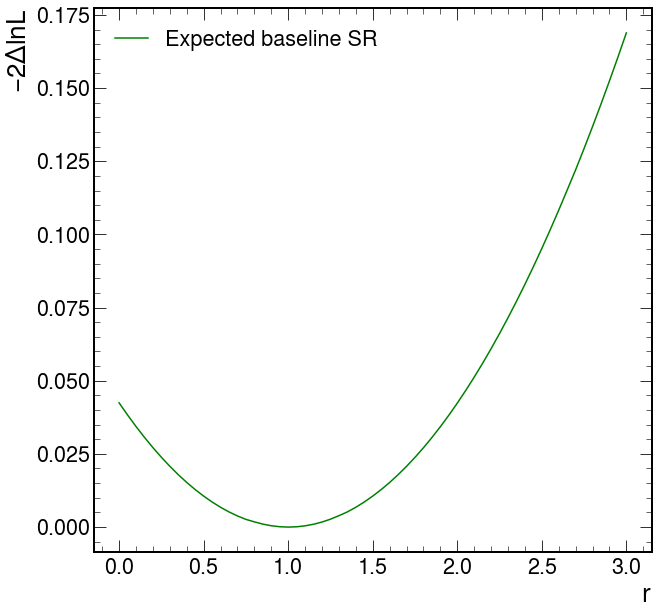

In [14]:
plt.figure()

plt.plot(result['r'][1:], result['deltaNLL'][1:]*2, label=r'Expected baseline SR', c='green')

plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [15]:
data_cards = {'2018_SR1': sm_card_sr1, '2018_SR2': sm_card_sr2, '2018_CR': sm_card_cr, '2018_CR_ext': sm_card_cr_ext}

combined = card.combineCards(data_cards)

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/4f7842a1-2810-4eff-9aef-b1a88b7f7c33
Copying card file to temp: SR_1_card.txt
Copying card file to temp: SR_2_card.txt
Copying card file to temp: CR_card.txt
Copying card file to temp: CR_ext_card.txt
 dc_2018_SR1=SR_1_card.txt dc_2018_SR2=SR_2_card.txt dc_2018_CR=CR_card.txt dc_2018_CR_ext=CR_ext_card.txt
Executing cd /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/4f7842a1-2810-4eff-9aef-b1a88b7f7c33; eval `scramv1 runtime -sh`; combineCards.py  dc_2018_SR1=SR_1_card.txt dc_2018_SR2=SR_2_card.txt dc_2018_CR=CR_card.txt dc_2018_CR_ext=CR_ext_card.txt > combinedCard.txt; text2workspace.py combinedCard.txt --X-allow-no-signal -m 125
Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/


In [16]:
result = card.nllScan(sm_card_sr1, rmin=0, rmax=3, npoints=61, options=' -v -1')

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/3bc16ff5-ac39-4e5c-a068-27662d1cf220


In [17]:
result_combined = card.nllScan(combined, rmin=0, rmax=3, npoints=61, options=' -v -1')

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/8a17a442-0bbf-43b6-ac5c-7836cc0871a1


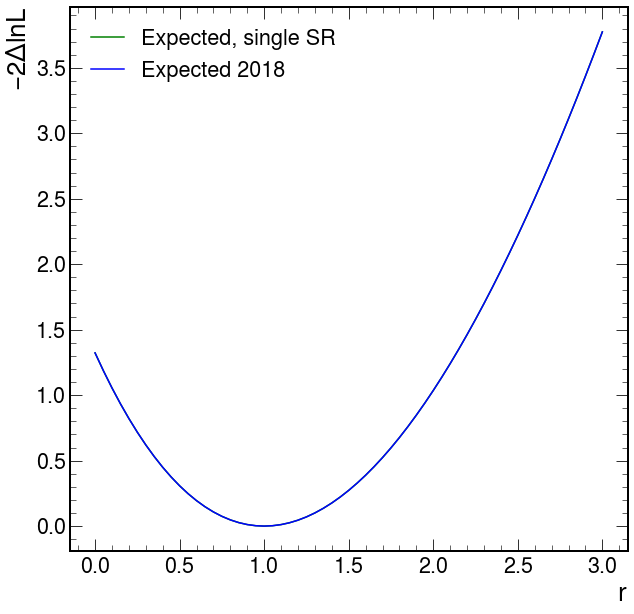

2018 significance: 1.323


In [18]:
plt.figure()

plt.plot(result['r'][1:], result['deltaNLL'][1:]*2, label=r'Expected, single SR', c='green')
plt.plot(result_combined['r'][1:], result_combined['deltaNLL'][1:]*2, label=r'Expected 2018', c='blue')


plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

print ("2018 significance: %.3f"%(result_combined['deltaNLL'][1]*2))

In [19]:
1.385/1.276

1.085423197492163

~10% improvement when including high stat CRs for normalization.


## Combining the years


In [20]:
cards = {}

for year in ['2016', '2016APV', '2017', '2018']:

    output = get_cache('SS_analysis_%s'%year)
    
    new_hists = {}
    for short_name, long_name in regions:
        new_hists[short_name] = output[long_name][no_data_or_signal]
        if short_name.count('CR_ext')<1:
            new_hists[short_name] = new_hists[short_name].rebin('score', score_bins)
        else:
            new_hists[short_name] = new_hists[short_name].rebin('multiplicity', N_bins)
        new_hists[short_name] = new_hists[short_name].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)
        
        
    cards['SR_1_%s'%year] = makeCardFromHist(
        new_hists,
        'SR_1',
        overflow='all',
        ext='_%s'%(year),
        systematics = systematics,
    )
    cards['SR_2_%s'%year] = makeCardFromHist(
        new_hists,
        'SR_2',
        overflow='all',
        ext='_%s'%(year),
        systematics = systematics,
    )
    cards['CR_%s'%year] = makeCardFromHist(
        new_hists,
        'CR',
        overflow='all',
        ext='_%s'%(year),
        systematics = systematics,
    )
    cards['CR_ext_%s'%year] = makeCardFromHist(
        new_hists,
        'CR_ext',
        overflow='none',
        ext='_%s'%(year),
        systematics = systematics,
    )

Writing cards using histogram: SR_1
Expectation for rare:         0.20
Expectation for TTW:          4.53
Expectation for TTZ:          2.32
Expectation for TTH:          1.67
Expectation for nonprompt:    2.22
Expectation for chargeflip:   0.00
Expectation for conversion:   2.22
Expectation for signal:       1.67
Observation:                  14.83
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1_2016_card.txt
Writing cards using histogram: SR_2
Expectation for rare:         0.14
Expectation for TTW:          2.47
Expectation for TTZ:          1.93
Expectation for TTH:          1.86
Expectation for nonprompt:    2.14
Expectation for chargeflip:   0.00
Expectation for conversion:   2.82
Expectation for signal:       0.88
Observation:                  12.24
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_1

In [21]:
combined_individual = {}

for year in ['2016', '2016APV', '2017', '2018']:
    combined_individual[year] = card.combineCards({
        'SR_1': cards['SR_1_%s'%year],
        'SR_2': cards['SR_2_%s'%year],
        'CR': cards['CR_%s'%year],
        'CR_ext': cards['CR_ext_%s'%year],
    })

combined_all = card.combineCards(cards);

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/e8c90257-1852-40c1-9fd3-bcffba25e7a1
Copying card file to temp: SR_1_2016_card.txt
Copying card file to temp: SR_2_2016_card.txt
Copying card file to temp: CR_2016_card.txt
Copying card file to temp: CR_ext_2016_card.txt
 dc_SR_1=SR_1_2016_card.txt dc_SR_2=SR_2_2016_card.txt dc_CR=CR_2016_card.txt dc_CR_ext=CR_ext_2016_card.txt
Executing cd /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/e8c90257-1852-40c1-9fd3-bcffba25e7a1; eval `scramv1 runtime -sh`; combineCards.py  dc_SR_1=SR_1_2016_card.txt dc_SR_2=SR_2_2016_card.txt dc_CR=CR_2016_card.txt dc_CR_ext=CR_ext_2016_card.txt > combinedCard.txt; text2workspace.py combinedCard.txt --X-allow-no-signal -m 125
Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/65e28b15-92de-4819-bc99-b9cc0b75d851
Copyi

In [22]:
result_2016APV = card.nllScan(combined_individual['2016APV'], rmin=0, rmax=3, npoints=61, options=' -v -1')
result_2016 = card.nllScan(combined_individual['2016'], rmin=0, rmax=3, npoints=61, options=' -v -1')
result_2017 = card.nllScan(combined_individual['2017'], rmin=0, rmax=3, npoints=61, options=' -v -1')
result_2018 = card.nllScan(combined_individual['2018'], rmin=0, rmax=3, npoints=61, options=' -v -1')

result_combined_all = card.nllScan(combined_all, rmin=0, rmax=3, npoints=61, options=' -v -1')

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/9961dfca-a7be-4a10-b8b9-b4a0321f2f5a
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/3bb72565-eaff-4c95-bc99-26ae0970fca9
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/eb87f62b-3812-4818-b4fc-12bac84e5612
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/5d16a563-d775-4b02-9493-1fc50d75cfa3
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/e49e9cf7-ba2e-42da-a852-bdb1110d9b8d


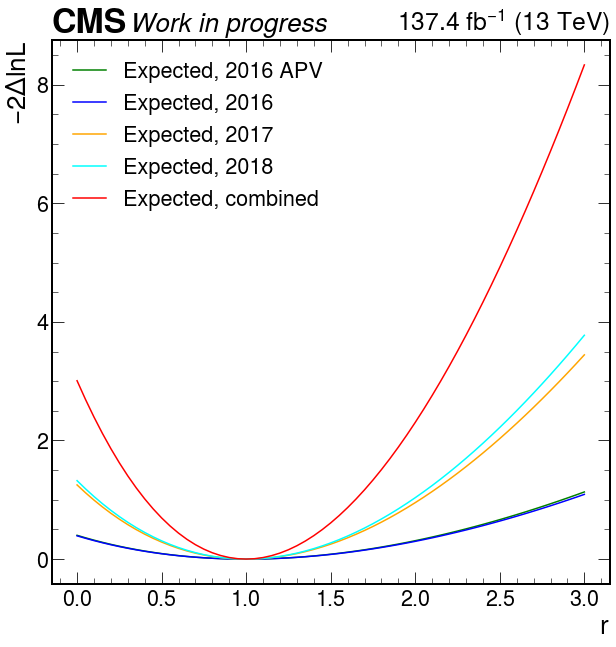

In [23]:
fig, ax = plt.subplots()

hep.cms.label(
    "Work in progress",
    data=True,
    #year=2018,
    lumi=60.0+41.5+35.9,
    loc=0,
    ax=ax,
)

plt.plot(result_2016APV['r'][1:], result_2016APV['deltaNLL'][1:]*2, label=r'Expected, 2016 APV', c='green')
plt.plot(result_2016['r'][1:], result_2016['deltaNLL'][1:]*2, label=r'Expected, 2016', c='blue')
plt.plot(result_2017['r'][1:], result_2017['deltaNLL'][1:]*2, label=r'Expected, 2017', c='orange')
plt.plot(result_2018['r'][1:], result_2018['deltaNLL'][1:]*2, label=r'Expected, 2018', c='cyan')
plt.plot(result_combined_all['r'][1:], result_combined_all['deltaNLL'][1:]*2, label=r'Expected, combined', c='red')

plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

fig.savefig('/home/users/dspitzba/public_html/tW_scattering/results_SS.pdf')
fig.savefig('/home/users/dspitzba/public_html/tW_scattering/results_SS.png')

In [24]:
result_combined_all['deltaNLL'][1]*2

3.0076141357421875

In [25]:
np.sqrt(result_combined_all['deltaNLL'][1]*2)

1.734247426332871

In [26]:
card.cleanUp()

Deleting:  /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/a74433ec-14a2-47f1-a62e-992789f5107f
Deleting:  /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/58bb889b-8477-4315-967f-cc0d2c38c207
Deleting:  /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/c74787ca-4b60-46be-8ac2-c54e795248a3
Deleting:  /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/edecda89-1d37-4e98-b7d5-8a73d471bb31
Deleting:  /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/3822486d-921c-4742-8634-8e77cdd9e5a8
Deleting:  /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/59136f06-71fa-4593-8484-4a17660753a4
Deleting:  /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/6aced329-264d-4a6b-97fb-2657ef44d95c
Deleting:  /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/4f7842a1-2810-4eff-9aef-b1a88b7f7c33
Deleting:  /home

## Adding trilep

In [27]:
# get one of our already existing caches

output = get_cache('trilep_analysis_2018')

Data: 0 MC: 24.33


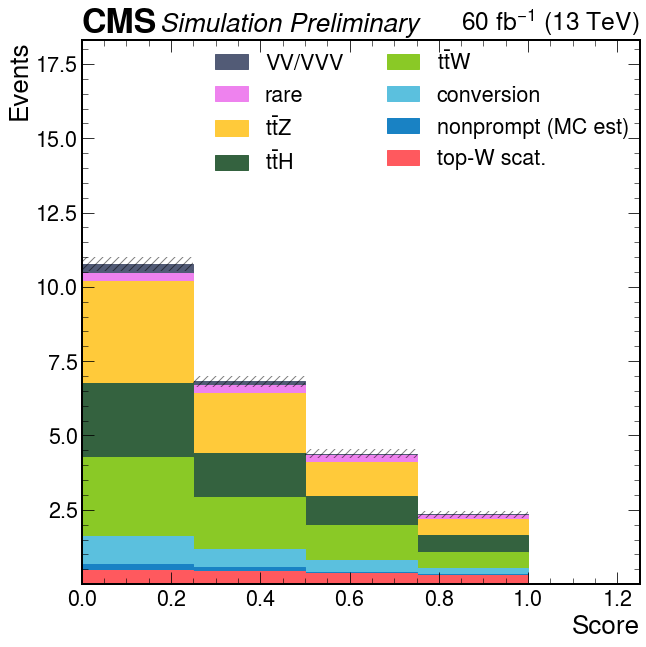

In [28]:
# check out that the histogram we want is actually there
all_processes = [ x[0] for x in output['N_ele'].values().keys() ]
data_all = ['DoubleMuon', 'MuonEG', 'EGamma', 'SingleMuon']
data    = data_all
order   = ['topW_v3', 'np_est_mc', 'conv_mc', 'TTW', 'TTH', 'TTZ','rare', 'diboson']
signals = []
omit    = [ x for x in all_processes if (x not in signals and x not in order and x not in data) ]

lumi = 60

score_bins = hist.Bin("score",          r"N", 4, 0, 1)  # 8 bins is a bit too fine, might work for 2018 but not other years

makePlot(output, 'node0_score_transform', 'score',
     data=[],
     bins=score_bins, log=False, normalize=False, axis_label='Score',
     new_colors=my_colors, new_labels=my_labels, lumi=lumi,
     order=order,
     signals=signals,
     omit=omit+data,
     #save=os.path.expandvars(plot_dir+sub_dir+'node0_score_transform_pp'),
    )

Data: 0 MC: 145.63


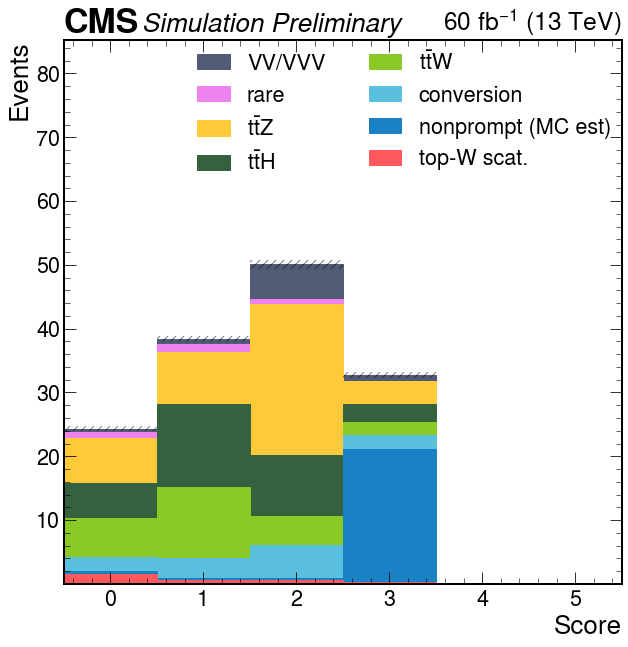

In [29]:
N_bins_all = hist.Bin("multiplicity",          r"N", 5, -0.5, 4.5)  # 8 bins is a bit too fine, might work for 2018 but not other years

makePlot(output, 'node', 'multiplicity',
     data=[],
     bins=N_bins_all, log=False, normalize=False, axis_label='Score',
     new_colors=my_colors, new_labels=my_labels, lumi=lumi,
     order=order,
     signals=signals,
     omit=omit+data,
     #save=os.path.expandvars(plot_dir+sub_dir+'node0_score_transform_pp'),
    )

In [30]:
no_data_or_signal  = re.compile('(?!(%s))'%('|'.join(omit)))

regions = [
    ('trilep_SR', 'node0_score_transform'),
    ('trilep_CR', 'node1_score'),
    ('trilep_CR_ext', 'node'),
]

mapping = {
    'rare': ['rare', 'diboson'],
    'TTW': ['TTW'],
    'TTZ': ['TTZ'],
    'TTH': ['TTH'],
    'ttbar': ['ttbar'],
    'nonprompt': ['np_est_mc'],
    'conversion': ['conv_mc'],
    'signal': ['topW_v3'],
}

new_hists = {}
for short_name, long_name in regions:
    new_hists[short_name] = output[long_name][no_data_or_signal]
    if short_name.count('CR_ext')<1:
        new_hists[short_name] = new_hists[short_name].rebin('score', score_bins)
    else:
        new_hists[short_name] = new_hists[short_name].rebin('multiplicity', N_bins)
    new_hists[short_name] = new_hists[short_name].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)

In [31]:
systematics = [
    ('ttw_norm', 1.15, 'TTW'),
    ('ttz_norm', 1.10, 'TTZ'),
    ('tth_norm', 1.20, 'TTH'),
    ('rare_norm', 1.20, 'rare'),
    ('nonprompt_norm', 1.30, 'nonprompt'),
    ('conversion_norm', 1.20, 'conversion')
]

sm_card_trilep_sr = makeCardFromHist(
    new_hists,
    'trilep_SR',
    overflow='all',
    ext='',
    systematics = systematics,
)

sm_card_trilep_cr = makeCardFromHist(
    new_hists,
    'trilep_CR',
    overflow='all',
    ext='',
    systematics = systematics,
)

Writing cards using histogram: trilep_SR
Expectation for rare:         1.40
Expectation for TTW:          6.10
Expectation for TTZ:          7.13
Expectation for TTH:          5.55
Expectation for nonprompt:    0.35
Expectation for conversion:   2.18
Expectation for signal:       1.62
Observation:                  24.33
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/trilep_SR_card.txt
Writing cards using histogram: trilep_CR
Expectation for rare:         2.14
Expectation for TTW:          11.13
Expectation for TTZ:          8.04
Expectation for TTH:          13.00
Expectation for nonprompt:    0.29
Expectation for conversion:   3.23
Expectation for signal:       0.59
Observation:                  38.41
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/trilep_CR_card.txt


In [32]:
data_cards = {'trilep_SR': sm_card_trilep_sr, 'trilep_CR': sm_card_trilep_cr}

combined = card.combineCards(data_cards)

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/14ce80d2-40a4-45ae-ac9c-aebb9f6c4112
Copying card file to temp: trilep_SR_card.txt
Copying card file to temp: trilep_CR_card.txt
 dc_trilep_SR=trilep_SR_card.txt dc_trilep_CR=trilep_CR_card.txt
Executing cd /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/14ce80d2-40a4-45ae-ac9c-aebb9f6c4112; eval `scramv1 runtime -sh`; combineCards.py  dc_trilep_SR=trilep_SR_card.txt dc_trilep_CR=trilep_CR_card.txt > combinedCard.txt; text2workspace.py combinedCard.txt --X-allow-no-signal -m 125
Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/


In [33]:
result_combined = card.nllScan(combined, rmin=0, rmax=3, npoints=61, options=' -v -1')

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/33630524-a20d-447c-91b4-9a43b82de8c0


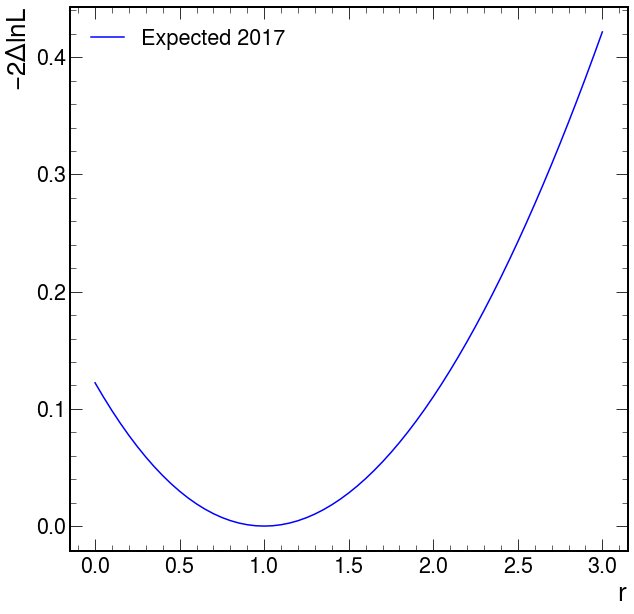

DeltaNLL at r=0: 0.122


In [34]:
plt.figure()

plt.plot(result_combined['r'][1:], result_combined['deltaNLL'][1:]*2, label=r'Expected 2017', c='blue')


plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

print ("DeltaNLL at r=0: %.3f"%(2*result_combined['deltaNLL'][1]))

0.111 for 2017 (individual)

In [35]:
cache_dir = '../caches/'

cards_trilep = {}

for year in ['2016', '2016APV', '2017', '2018']:

    cache_name = 'trilep_analysis_%s'%year

    cache = dir_archive(cache_dir+cache_name, serialized=True)
    cache.load()
    output = cache.get('simple_output')
    
    new_hists = {}
    for short_name, long_name in regions:
        new_hists[short_name] = output[long_name][no_data_or_signal]
        if short_name.count('CR_ext')<1:
            new_hists[short_name] = new_hists[short_name].rebin('score', score_bins)
        else:
            new_hists[short_name] = new_hists[short_name].rebin('multiplicity', N_bins)
        #new_hists[short_name] = new_hists[short_name].rebin('score', score_bins)
        new_hists[short_name] = new_hists[short_name].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)
        
        
    cards_trilep['trilep_SR_%s'%year] = makeCardFromHist(
        new_hists,
        'trilep_SR',
        overflow='all',
        ext='_%s'%(year),
        systematics = systematics,
    )
    
    cards_trilep['trilep_CR_%s'%year] = makeCardFromHist(
        new_hists,
        'trilep_CR',
        overflow='all',
        ext='_%s'%(year),
        systematics = systematics,
    )
    
    cards_trilep['trilep_CR_ext_%s'%year] = makeCardFromHist(
        new_hists,
        'trilep_CR_ext',
        overflow='all',
        ext='_%s'%(year),
        systematics = systematics,
    )

Writing cards using histogram: trilep_SR
Expectation for rare:         0.14
Expectation for TTW:          1.01
Expectation for TTZ:          2.55
Expectation for TTH:          0.78
Expectation for nonprompt:    0.33
Expectation for conversion:   1.05
Expectation for signal:       0.39
Observation:                  6.26
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/trilep_SR_2016_card.txt
Writing cards using histogram: trilep_CR
Expectation for rare:         0.29
Expectation for TTW:          3.27
Expectation for TTZ:          3.96
Expectation for TTH:          3.20
Expectation for nonprompt:    0.35
Expectation for conversion:   1.73
Expectation for signal:       0.17
Observation:                  12.97
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/trilep_CR_2016_card.t

In [36]:
combined_trilep_individual = {}

for year in ['2016', '2016APV', '2017', '2018']:
    combined_trilep_individual[year] = card.combineCards({
        'trilep_SR': cards_trilep['trilep_SR_%s'%year],
        'trilep_CR': cards_trilep['trilep_CR_%s'%year],
        'trilep_CR_ext': cards_trilep['trilep_CR_ext_%s'%year],
    })

combined_trilep_all = card.combineCards(cards_trilep);

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/96042119-c130-4d0a-b1fe-9b0313342e47
Copying card file to temp: trilep_SR_2016_card.txt
Copying card file to temp: trilep_CR_2016_card.txt
Copying card file to temp: trilep_CR_ext_2016_card.txt
 dc_trilep_SR=trilep_SR_2016_card.txt dc_trilep_CR=trilep_CR_2016_card.txt dc_trilep_CR_ext=trilep_CR_ext_2016_card.txt
Executing cd /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/96042119-c130-4d0a-b1fe-9b0313342e47; eval `scramv1 runtime -sh`; combineCards.py  dc_trilep_SR=trilep_SR_2016_card.txt dc_trilep_CR=trilep_CR_2016_card.txt dc_trilep_CR_ext=trilep_CR_ext_2016_card.txt > combinedCard.txt; text2workspace.py combinedCard.txt --X-allow-no-signal -m 125
Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/6953d3cd-0617-4a53-a433-fd448d8f8929
Copying ca

In [37]:
combined_trilep_individual

{'2016': '/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/COMBINED_2016_card.txt',
 '2016APV': '/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/COMBINED_2016APV_card.txt',
 '2017': '/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/COMBINED_2017_card.txt',
 '2018': '/home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/COMBINED_2018_card.txt'}

In [38]:
result_trilep_2016APV = card.nllScan(combined_trilep_individual['2016APV'], rmin=0, rmax=3, npoints=61, options=' -v -1')
result_trilep_2016 = card.nllScan(combined_trilep_individual['2016'], rmin=0, rmax=3, npoints=61, options=' -v -1')
result_trilep_2017 = card.nllScan(combined_trilep_individual['2017'], rmin=0, rmax=3, npoints=61, options=' -v -1')
result_trilep_2018 = card.nllScan(combined_trilep_individual['2018'], rmin=0, rmax=3, npoints=61, options=' -v -1')

result_trilep_combined_all = card.nllScan(combined_trilep_all, rmin=0, rmax=3, npoints=61, options=' -v -1')

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/0c761010-e693-4d29-aa99-fa000e707e62
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/237af43f-443d-4884-b8d4-4a84b04311f4
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/5d707c2a-8107-4dfe-b26c-1ee12fe09e58
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/be624c8a-3397-4482-8a5a-26aa5dd71ac7
Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/aa111162-f9f8-47a6-b3b5-c06512ab63f7


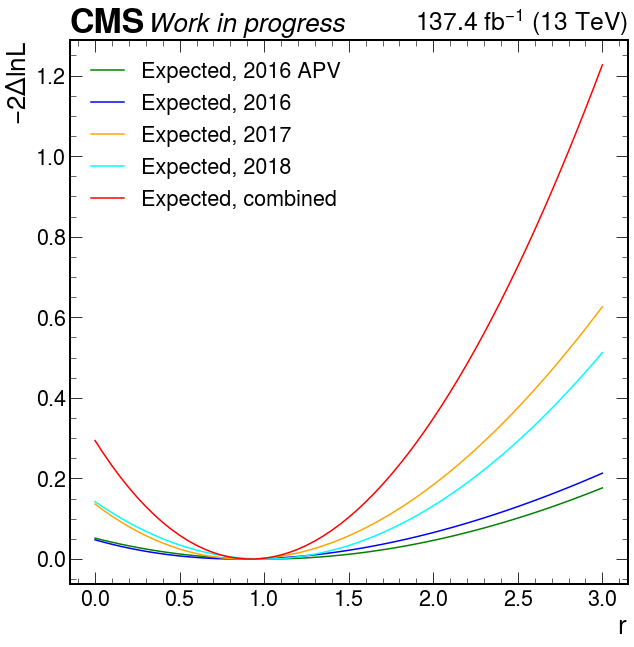

In [39]:
fig, ax = plt.subplots()

hep.cms.label(
    "Work in progress",
    data=True,
    #year=2018,
    lumi=60.0+41.5+35.9,
    loc=0,
    ax=ax,
)

plt.plot(result_trilep_2016APV['r'][1:], result_trilep_2016APV['deltaNLL'][1:]*2, label=r'Expected, 2016 APV', c='green')
plt.plot(result_trilep_2016['r'][1:], result_trilep_2016['deltaNLL'][1:]*2, label=r'Expected, 2016', c='blue')
plt.plot(result_trilep_2017['r'][1:], result_trilep_2017['deltaNLL'][1:]*2, label=r'Expected, 2017', c='orange')
plt.plot(result_trilep_2018['r'][1:], result_trilep_2018['deltaNLL'][1:]*2, label=r'Expected, 2018', c='cyan')
plt.plot(result_trilep_combined_all['r'][1:], result_trilep_combined_all['deltaNLL'][1:]*2, label=r'Expected, combined', c='red')

plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

fig.savefig('/home/users/dspitzba/public_html/tW_scattering/results_trilep.pdf')
fig.savefig('/home/users/dspitzba/public_html/tW_scattering/results_trilep.png')

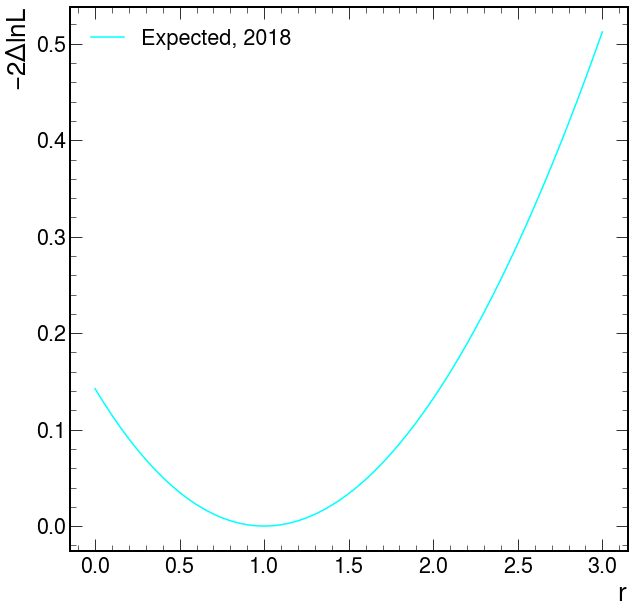

In [40]:
plt.figure()

#plt.plot(result_trilep_2016APV['r'][1:], result_trilep_2016APV['deltaNLL'][1:]*2, label=r'Expected, 2016 APV', c='green')
#plt.plot(result_trilep_2016['r'][1:], result_trilep_2016['deltaNLL'][1:]*2, label=r'Expected, 2016', c='blue')
#plt.plot(result_trilep_2017['r'][1:], result_trilep_2017['deltaNLL'][1:]*2, label=r'Expected, 2017', c='orange')
plt.plot(result_trilep_2018['r'][1:], result_trilep_2018['deltaNLL'][1:]*2, label=r'Expected, 2018', c='cyan')
#plt.plot(result_trilep_combined_all['r'][1:], result_trilep_combined_all['deltaNLL'][1:]*2, label=r'Expected, combined', c='red')

plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

# Everything

In [41]:
cards_all = cards
cards_all.update(cards_trilep)

combined_final = card.combineCards(cards_all);

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/20e64c17-5987-4cfa-874f-2dc03d8bafd8
Copying card file to temp: SR_1_2016_card.txt
Copying card file to temp: SR_2_2016_card.txt
Copying card file to temp: CR_2016_card.txt
Copying card file to temp: CR_ext_2016_card.txt
Copying card file to temp: SR_1_2016APV_card.txt
Copying card file to temp: SR_2_2016APV_card.txt
Copying card file to temp: CR_2016APV_card.txt
Copying card file to temp: CR_ext_2016APV_card.txt
Copying card file to temp: SR_1_2017_card.txt
Copying card file to temp: SR_2_2017_card.txt
Copying card file to temp: CR_2017_card.txt
Copying card file to temp: CR_ext_2017_card.txt
Copying card file to temp: SR_1_2018_card.txt
Copying card file to temp: SR_2_2018_card.txt
Copying card file to temp: CR_2018_card.txt
Copying card file to temp: CR_ext_2018_card.txt
Copying card file to temp: trilep_SR_2016_card.txt
Copying card file to temp: trilep_CR_2016_card.txt
Copying card file to temp: tr

In [42]:
result_all = card.nllScan(combined_final, rmin=0, rmax=3, npoints=61, options=' -v -1')

Creating /home/users/dspitzba/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/9d4d96f5-0d6f-4cfa-bf57-363ced9186b2


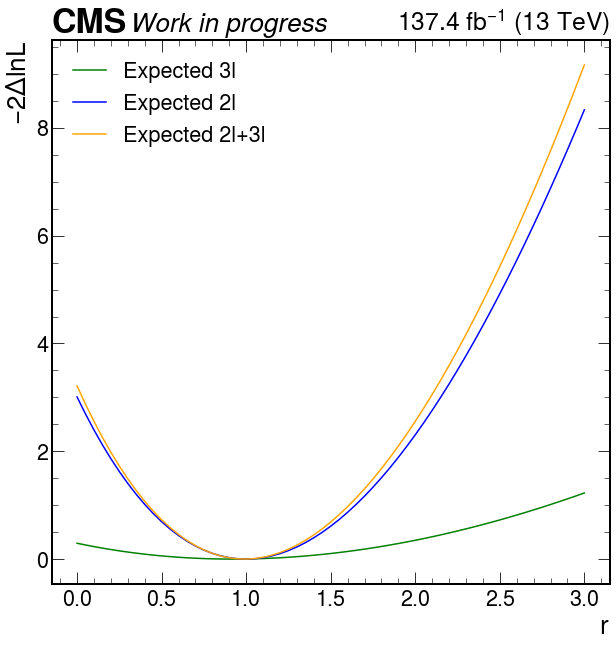

In [43]:
fig, ax = plt.subplots()

hep.cms.label(
    "Work in progress",
    data=True,
    #year=2018,
    lumi=60.0+41.5+35.9,
    loc=0,
    ax=ax,
)

plt.plot(result_trilep_combined_all['r'][1:], result_trilep_combined_all['deltaNLL'][1:]*2, label=r'Expected 3l', c='green')
plt.plot(result_combined_all['r'][1:], result_combined_all['deltaNLL'][1:]*2, label=r'Expected 2l', c='blue')
plt.plot(result_all['r'][1:], result_all['deltaNLL'][1:]*2, label=r'Expected 2l+3l', c='orange')

plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

fig.savefig('/home/users/dspitzba/public_html/tW_scattering/results_combined.pdf')
fig.savefig('/home/users/dspitzba/public_html/tW_scattering/results_combined.png')

In [44]:
result_all['deltaNLL'][1]*2

3.21333909034729

In [45]:
np.sqrt(result_all['deltaNLL'][1]*2)

1.792578893758177

## BSM code

In [27]:
card = dataCard(releaseLocation=os.path.expandvars('/home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/'))

In [35]:
output = get_cache('SS_analysis_2017')
output_EFT = get_cache('EFT_cpt_scan_2017')

regions_EFT = [
    ('SR_1', 'LT_SR_pp'),
    ('SR_2', 'LT_SR_mm'),
    #('CR', 'node1_score'),
    ('CR_ext', 'node'),
]

#pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', [0,100,150,200,400])
ht_bins_coarse = hist.Bin('ht', r'$p_{T}\ (GeV)$', [0,200,400,600,800])
N_bins = hist.Bin("multiplicity", r"N", 3, 1.5, 4.5)

new_hists_EFT = {}
for short_name, long_name in regions_EFT:
    print (short_name, long_name)
    new_hists_EFT[short_name] = output[long_name][no_data_or_signal]
    if short_name.count('CR_ext')<1:
        new_hists_EFT[short_name] = new_hists_EFT[short_name].rebin('ht', ht_bins_coarse)
    else:
        new_hists_EFT[short_name] = new_hists_EFT[short_name].rebin('multiplicity', N_bins)
    new_hists_EFT[short_name] = new_hists_EFT[short_name].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)

    

eft_card_sr1 = makeCardFromHist(
    new_hists_EFT,
    'SR_1',
    overflow='all',
    ext='EFT',
    systematics = systematics,
    signal_hist = output_EFT['LT_SR_pp']['topW_full_EFT_cpt_8.0'].rebin('ht', ht_bins_coarse)  ## need to fix the binning of the EFT hist!!
)

eft_card_sr2 = makeCardFromHist(
    new_hists_EFT,
    'SR_2',
    overflow='all',
    ext='EFT',
    systematics = systematics,
    signal_hist = output_EFT['LT_SR_mm']['topW_full_EFT_cpt_8.0'].rebin('ht', ht_bins_coarse)
)

sm_card_sr1 = makeCardFromHist(
    new_hists_EFT,
    'SR_1',
    overflow='all',
    ext='SM',
    systematics = systematics,
)

sm_card_sr2 = makeCardFromHist(
    new_hists_EFT,
    'SR_2',
    overflow='all',
    ext='SM',
    systematics = systematics,
)

SR_1 LT_SR_pp
SR_2 LT_SR_mm
CR_ext node
Writing cards using histogram: SR_1
Expectation for rare:         2.32
Expectation for TTW:          12.53
Expectation for TTZ:          3.69
Expectation for TTH:          6.94
Expectation for nonprompt:    4.61
Expectation for chargeflip:   0.00
Expectation for conversion:   1.48
Expectation for signal:       12.46
Observation:                  36.31
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1EFT_card.txt
Writing cards using histogram: SR_2
Expectation for rare:         1.89
Expectation for TTW:          6.45
Expectation for TTZ:          3.35
Expectation for TTH:          6.69
Expectation for nonprompt:    4.87
Expectation for chargeflip:   0.00
Expectation for conversion:   1.85
Expectation for signal:       5.71
Observation:                  27.63
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written ca

In [36]:
combined_EFT = card.combineCards({'EFT1': eft_card_sr1, 'EFT2': eft_card_sr2})
combined_SM = card.combineCards({'SM1': sm_card_sr1, 'SM2': sm_card_sr2})

Creating /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/145cc5c4-b682-44f5-8018-d2f1e8a93840
Copying card file to temp: SR_1EFT_card.txt
Copying card file to temp: SR_2EFT_card.txt
 dc_EFT1=SR_1EFT_card.txt dc_EFT2=SR_2EFT_card.txt
Executing cd /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/145cc5c4-b682-44f5-8018-d2f1e8a93840; eval `scramv1 runtime -sh`; combineCards.py  dc_EFT1=SR_1EFT_card.txt dc_EFT2=SR_2EFT_card.txt > combinedCard.txt; text2workspace.py combinedCard.txt --X-allow-no-signal -m 125
Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/
Creating /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/319f8b3b-fcc4-4b49-b77a-e06ebaf8abae
Copying card file to temp: SR_1SM_card.txt
Copying card file to temp: SR_2SM_card.txt
 dc_SM1=SR_1SM_card.txt dc_SM2=SR_2SM_card.txt
Executing cd /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/319f8b3b-fcc

In [37]:
res_bsm = card.calcNLL(combined_EFT)
res_sm = card.calcNLL(combined_SM)

Creating /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/c776027c-2c92-4db8-aa8e-f26086e0b2d6
Creating /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/a72546cf-e300-490f-9625-440601f61fb2


In [38]:
res_sm['nll0'][0]+res_sm['nll'][0]

62.05695438639333

In [39]:
res_bsm['nll0'][0]+res_bsm['nll'][0]

63.66831884466929

In [40]:
-2*(res_sm['nll0'][0]+res_sm['nll'][0]- (res_bsm['nll0'][0]+res_bsm['nll'][0]))

3.2227289165519153

2017 lepton pT: 2.80

2017 LT: 3.22

In [62]:
from Tools.EFT_tools import make_scan

signal_points = make_scan(operator='ctW', C_min=-2.5, C_max=2.5, step=0.25)

def get_scan(signal_points):

    delta_NLL = []
        
    regions_EFT = [
            ('SR_1', 'LT_SR_pp'),
            ('SR_2', 'LT_SR_mm'),
            #('CR', 'node1_score'),
            ('CR_ext', 'node'),
    ]
        
    pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', [0,100,150,200,400])
    ht_bins_coarse = hist.Bin('ht', r'$p_{T}\ (GeV)$', [0,200,400,600,800])
    N_bins = hist.Bin("multiplicity", r"N", 3, 1.5, 4.5)
    
    all_SM_cards = {}
    
    new_hists_EFT = {}
    
    print ("Working on SM cards:")
    
    for year in ['2016', '2016APV', '2017', '2018']:
    
        print ("Year/Era:", year)
        output = get_cache('SS_analysis_%s'%year)
        
        new_hists_EFT[year] = {}
        
        for short_name, long_name in regions_EFT:
            new_hists_EFT[year][short_name] = output[long_name][no_data_or_signal]
            if short_name.count('CR_ext')<1:
                new_hists_EFT[year][short_name] = new_hists_EFT[year][short_name].rebin('ht', ht_bins_coarse)
            else:
                new_hists_EFT[year][short_name] = new_hists_EFT[year][short_name].rebin('multiplicity', N_bins)
            new_hists_EFT[year][short_name] = new_hists_EFT[year][short_name].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)
        
        all_SM_cards[year+'_sr1'] = makeCardFromHist(
            new_hists_EFT[year],
            'SR_1',
            overflow='all',
            ext='SM'+year,
            systematics = systematics,
        )
        
        all_SM_cards[year+'_sr2'] = makeCardFromHist(
            new_hists_EFT[year],
            'SR_2',
            overflow='all',
            ext='SM'+year,
            systematics = systematics,
        )
    
    
    combined_SM = card.combineCards(all_SM_cards)
    res_sm = card.calcNLL(combined_SM)
    
    print ("Done with SM cards.")
    
    for point in signal_points:
        
        print (point)
        
        all_EFT_cards = {}
        for year in ['2016', '2016APV', '2017', '2018']:
            
            print (year)
            
            output_EFT = get_cache('EFT_ctW_scan_%s'%year)
                
            all_EFT_cards[year+'_sr1'] = makeCardFromHist(
                new_hists_EFT[year],
                'SR_1',
                overflow='all',
                ext='EFT'+year,
                systematics = systematics,
                quiet=True,
                signal_hist = output_EFT['LT_SR_pp']['topW_full_EFT_'+point['name']].rebin('ht', ht_bins_coarse)  ## need to fix the binning of the EFT hist!!
            )
            
            all_EFT_cards[year+'_sr2'] = makeCardFromHist(
                new_hists_EFT[year],
                'SR_2',
                overflow='all',
                ext='EFT'+year,
                systematics = systematics,
                quiet=True,
                signal_hist = output_EFT['LT_SR_mm']['topW_full_EFT_'+point['name']].rebin('ht', ht_bins_coarse)
            )
            
        combined_EFT = card.combineCards(all_EFT_cards)
            
        res_bsm = card.calcNLL(combined_EFT)
            
        delta_NLL.append({'cpt': point['point'][4], 'limit': -2*(res_sm['nll0'][0]+res_sm['nll'][0]- (res_bsm['nll0'][0]+res_bsm['nll'][0]))})
        
    return delta_NLL

In [63]:
card.cleanUp()

Deleting:  /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/08196eea-70e3-4d0a-94f0-eab3760b8739
Deleting:  /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/03c2e6f7-1d6f-4fbc-ab10-b1a193ccff62
Deleting:  /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/fa24e3c6-2ed2-4135-9646-b9ee6c4d77ed
Deleting:  /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/fa9a5064-145b-48e6-8940-b46d73222896
Deleting:  /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/f04a2903-d61f-4167-ba2f-43048ff4c568
Deleting:  /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/f6e31f93-dffc-4d35-9304-b0a026cc2082
Deleting:  /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/0d167dbb-8914-42d8-9736-1d91aab9d13c
Deleting:  /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/c1e369e1-5d4c-440d-8562-cf00e56d8b66
Deleting:  /home/users/dspitzba/TTW/CMSSW_10_2_1

In [64]:
test = get_scan(signal_points)

Working on SM cards:
Year/Era: 2016
Writing cards using histogram: SR_1
Expectation for rare:         0.20
Expectation for TTW:          4.53
Expectation for TTZ:          2.32
Expectation for TTH:          1.67
Expectation for nonprompt:    2.22
Expectation for chargeflip:   0.00
Expectation for conversion:   2.22
Expectation for signal:       1.67
Observation:                  14.83
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1SM2016_card.txt
Writing cards using histogram: SR_2
Expectation for rare:         0.14
Expectation for TTW:          2.47
Expectation for TTZ:          1.93
Expectation for TTH:          1.86
Expectation for nonprompt:    2.14
Expectation for chargeflip:   0.00
Expectation for conversion:   2.82
Expectation for signal:       0.88
Observation:                  12.24
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card 

Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/
Creating /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/e87a4f2d-11c0-4d35-a9be-154f20a3fc46
{'name': 'ctW_-2.2', 'point': [0, 0, 0, 0, -2.25, 0]}
2016
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1EFT2016_card.txt
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_2EFT2016_card.txt
2016APV
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1EFT2016APV_card.txt
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_2EFT2016APV_card.txt
2017
Adding  lumi = 1.03 for al

Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/
Creating /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/c4bbcaca-941c-4ab5-a3c9-a7a3d26a0a16
{'name': 'ctW_-1.5', 'point': [0, 0, 0, 0, -1.5, 0]}
2016
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1EFT2016_card.txt
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_2EFT2016_card.txt
2016APV
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1EFT2016APV_card.txt
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_2EFT2016APV_card.txt
2017
Adding  lumi = 1.03 for all

Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/
Creating /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/5f4159e0-581b-4e5a-9f40-a1ef9413fe82
{'name': 'ctW_-0.8', 'point': [0, 0, 0, 0, -0.75, 0]}
2016
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1EFT2016_card.txt
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_2EFT2016_card.txt
2016APV
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1EFT2016APV_card.txt
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_2EFT2016APV_card.txt
2017
Adding  lumi = 1.03 for al

Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/
Creating /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/7f3c344e-cdef-462a-b926-020f3d98aff8
{'name': 'ctW_0.0', 'point': [0, 0, 0, 0, 0.0, 0]}
2016
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1EFT2016_card.txt
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_2EFT2016_card.txt
2016APV
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1EFT2016APV_card.txt
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_2EFT2016APV_card.txt
2017
Adding  lumi = 1.03 for all b

Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/
Creating /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/e53bce48-30d0-4573-8638-06c052a1580c
{'name': 'ctW_0.8', 'point': [0, 0, 0, 0, 0.75, 0]}
2016
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1EFT2016_card.txt
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_2EFT2016_card.txt
2016APV
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1EFT2016APV_card.txt
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_2EFT2016APV_card.txt
2017
Adding  lumi = 1.03 for all 

Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/
Creating /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/28069eac-bc88-494e-bf46-f1f153f50459
{'name': 'ctW_1.5', 'point': [0, 0, 0, 0, 1.5, 0]}
2016
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1EFT2016_card.txt
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_2EFT2016_card.txt
2016APV
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1EFT2016APV_card.txt
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_2EFT2016APV_card.txt
2017
Adding  lumi = 1.03 for all b

Putting combined card into dir /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/
Creating /home/users/dspitzba/TTW/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/18bedb0d-8667-4265-93b0-8f5e6b8bf246
{'name': 'ctW_2.2', 'point': [0, 0, 0, 0, 2.25, 0]}
2016
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1EFT2016_card.txt
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_2EFT2016_card.txt
2016APV
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_1EFT2016APV_card.txt
Adding  lumi = 1.03 for all bins and processes!
[cardFileWrite] Written card file /home/users/dspitzba/TTW/CMSSW_10_2_9/src/tW_scattering/data/cards/SR_2EFT2016APV_card.txt
2017
Adding  lumi = 1.03 for all 

In [65]:
test_df = pd.DataFrame(test)
test_df

,cpt,limit
0,-2.50,23.736442
1,-2.25,16.891078
2,-2.00,11.438875
3,-1.75,7.266498
4,-1.50,4.239623
5,-1.25,2.201442
6,-1.00,0.971583
7,-0.75,0.348290
8,-0.50,0.116506
9,-0.25,0.071674


-14.2 to 16.4 with lepton pt.

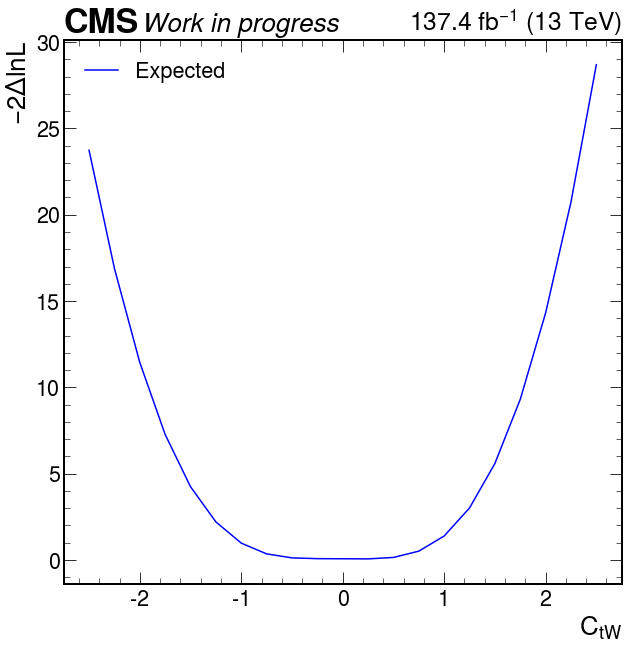

In [66]:
fig, ax = plt.subplots()

hep.cms.label(
    "Work in progress",
    data=True,
    #year=2018,
    lumi=60.0+41.5+35.9,
    loc=0,
    ax=ax,
)

plt.plot(test_df['cpt'][0:], test_df['limit'][0:], label=r'Expected', c='blue')

plt.xlabel(r'$C_{tW}$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

fig.savefig('/home/users/dspitzba/public_html/tW_scattering/ctW.pdf')
fig.savefig('/home/users/dspitzba/public_html/tW_scattering/ctW.png')

